# Challenge Description
We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.
As said above, the goal is to predict employee retention and understand its main drivers.
#### Specifically, you should:
* Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
* You should create a table with 3 columns: day, employee_headcount, company_id.

####   What are the main factors that drive employee churn? Do they make sense? Explain your findings.
####  If you could add to this data set just one variable that could help explain employee churn,
what would that be?

### Table "employee_retention" - comprehensive information about employees
#### Columns:
* **employee_id :** id of the employee. Unique by employee per company<br />
* **company_id :** company id.<br />
* **dept :** employee dept<br />
* **seniority :** number of yrs of work experience when hired<br />
* **salary:** avg yearly salary of the employee during her tenure within the company<br />
* **join_date:** when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13<br />
* **quit_date:** when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)<br />

In [1]:
import pandas as pd
df = pd.read_csv('employee_retention_data.csv',index_col=False)

# Data peaking and Analysis

In [2]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
df['join_date']= pd.to_datetime(df['join_date'])
df['quit_date']= pd.to_datetime(df['quit_date'])

In [4]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [6]:
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [7]:
print df.employee_id.nunique()
print df.employee_id.count()

24702
24702


In [8]:
#number of people who retained or quitted
no_employess = df.employee_id.nunique()
total_retained = df.quit_date.isnull().sum()
total_quitted = no_employess - total_retained
print 'no_employees = {0} total_retained = {1} quitted={2}'.format(no_employess,total_retained,total_quitted)

no_employees = 24702 total_retained = 11192 quitted=13510


In [9]:
#number of employees per company
df.company_id.value_counts()

1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
12      24
11      16
Name: company_id, dtype: int64

# Feature Engineering

In [10]:
df['quit']=0
df.loc[df['quit_date'].notnull(), 'quit'] = 1

In [11]:
from datetime import datetime,timedelta
import numpy as np
df.loc[df['quit_date'].notnull(),'duration_stay'] = df.quit_date - df.join_date
end_date = datetime.strptime('2015-12-04', '%Y-%m-%d').date()
df.loc[df['quit_date'].isnull(),'duration_stay'] = (end_date - df.join_date)
df['duration_stay'] =df['duration_stay'] / np.timedelta64(1, 'D')
df['duration_stay'] = df['duration_stay'].astype(int)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,duration_stay
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,417
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040


In [13]:
#Divide dataset into two one for employees still there and one for people who left
#remove quit date in the people who stated
df_stayed =df[df['quit_date'].isnull()]
df_stayed.drop(['quit_date'],axis=1,inplace=True)
df_quit =df[df['quit_date'].notnull()]
print df.shape,df_stayed.shape,df_quit.shape

(24702, 9) (11192, 8) (13510, 9)


/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


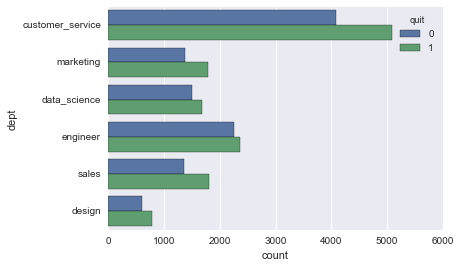

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure()
sns.set(style="darkgrid")
ax1 = sns.countplot(y='dept',hue='quit',data=df)

In [15]:
#number of people who retained or left the each company
company_stayed = df_stayed.groupby(df['company_id']).agg({'employee_id':'count'}).add_prefix('retained_').reset_index()
company_quit = df_quit.groupby(df['company_id']).agg({'employee_id':'count'}).add_prefix('quited_').reset_index()


In [16]:
company_stayed_quit=pd.merge(company_stayed,company_quit,on=['company_id'],how='left')
company_stayed_quit

,company_id,retained_employee_id,quited_employee_id
0,1,3865,4621
1,2,2016,2206
2,3,1218,1531
3,4,909,1153
4,5,772,983
5,6,579,712
6,7,532,692
7,8,468,579
8,9,432,529
9,10,385,480


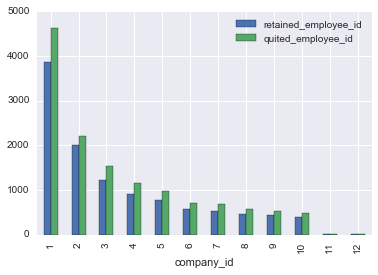

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

company_stayed_quit.plot.bar(x='company_id')
#plt.plot(kind='bar'y=company_stayed_quit[["retained_employee_id"]])

In [18]:
#average length each employee stayed in a compnay


# Build Headcount dataframe

In [19]:
base = '2011/01/24'
end = '2015/12/13'
date_range = pd.date_range(base,end)

In [20]:
company_headcount = pd.DataFrame(columns=['day', "employee_headcount", "company_id"])
company_headcount_list = []

for day in date_range:
    
    new_df_quit = df[df['join_date']<=day ]
    people_not_quitedYet = new_df_quit[new_df_quit['quit_date']>day]
    company_headcount_quit = people_not_quitedYet.groupby(people_not_quitedYet['company_id']).employee_id.agg({'employee_headcount_quit':'count'}).reset_index()
    company_headcount_quit['day'] = day
    
    new_df_stayed = df_stayed[df['join_date']<=day ]
    company_headcount_stayed = new_df_stayed.groupby(new_df_stayed['company_id']).employee_id.agg({'employee_headcount_stay':'count'}).reset_index()
    company_headcount_stayed['day'] = day
    
    company_headcount_temp= pd.merge(company_headcount_quit,company_headcount_stayed,how='outer',on=['company_id','day'])
    company_headcount_temp.fillna(0,inplace=True)
    company_headcount_temp["employee_headcount"] = company_headcount_temp["employee_headcount_quit"]+company_headcount_temp["employee_headcount_stay"]
    
    company_headcount_list.append(company_headcount_temp)
    
company_headcount= pd.concat(company_headcount_list,axis=0)

/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [21]:
company_headcount.head()

,company_id,day,employee_headcount,employee_headcount_quit,employee_headcount_stay
0,1,2011-01-24,25.0,25.0,0.0
1,2,2011-01-24,17.0,17.0,0.0
2,3,2011-01-24,9.0,9.0,0.0
3,4,2011-01-24,12.0,12.0,0.0
4,5,2011-01-24,5.0,5.0,0.0


In [22]:
company_headcount['company_id'].value_counts()

9     1785
8     1785
7     1785
6     1785
5     1785
4     1785
3     1785
2     1785
1     1785
10    1778
11    1756
12    1736
Name: company_id, dtype: int64

In [23]:
#ax = sns.pointplot(x="day", y="employee_headcount", hue="company_id",data=company_headcount, dodge=True)
hc_date = company_headcount[company_headcount['company_id']==12]
print hc_date['day'].count(),hc_date['day'].nunique(),len(date_range)
print hc_date['company_id'].count(),hc_date['company_id'].nunique()
#hc_date[['day','employee_headcount']].plot.bar(x='day')

1736 1736 1785
1736 1


# Statistical Analysis and Visualization

1 1785
2 1785
3 1785
4 1785
5 1785
6 1785
7 1785
8 1785
9 1785
10 1778
11 1756
12 1736


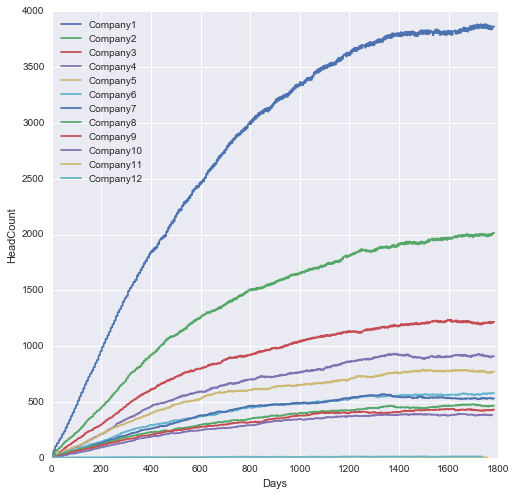

In [24]:
plt.figure(figsize = (8,8))
#days = len(date_range)

plt.xlabel('Days')
plt.ylabel('HeadCount')
for comp_id in company_headcount['company_id'].unique():
    hc = company_headcount[company_headcount['company_id']==comp_id].employee_headcount
    print comp_id,len(hc)
    #plt.plot(range(days),hc)
    plt.plot(range(len(hc)),hc,label = 'Company{}'.format(comp_id))

plt.legend(loc="upper left")
plt.show()

1 1785
2 1785
3 1785
4 1785
5 1785
6 1785
7 1785
8 1785
9 1785
10 1778
11 1756
12 1736


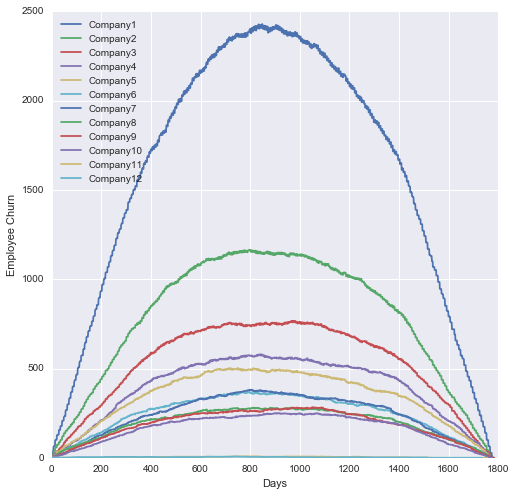

In [39]:
plt.figure(figsize = (8,8))
#days = len(date_range)

plt.xlabel('Days')
plt.ylabel('Employee Churn')
for comp_id in company_headcount['company_id'].unique():
    hc = company_headcount[company_headcount['company_id']==comp_id].employee_headcount_quit
    print comp_id,len(hc)
    #plt.plot(range(days),hc)
    plt.plot(range(len(hc)),hc,label = 'Company{}'.format(comp_id))

plt.legend(loc="upper left")
plt.show()

# Resposible factores in people quiting their jobs

We use statistical approaches to see which features are important in person staying or leaving a job based 
on box plots + distributions + corralation to the class label (stay/quit)
it shows that seniority and salary doesn't have much effect but the duration of stay in the company is a significant factor
previously we saw that department and type of jib are not significant factors either

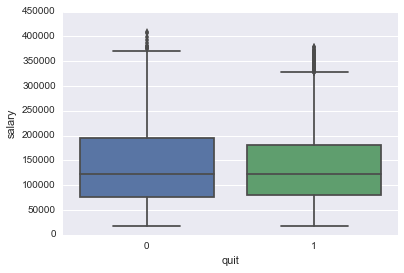

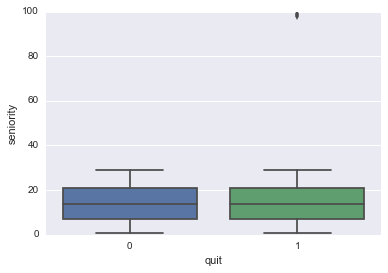

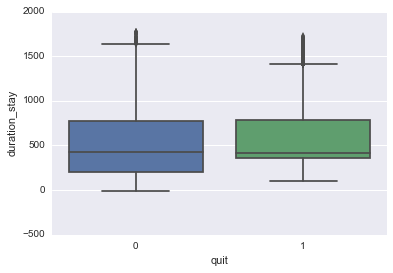

In [25]:
plt.figure()
sns.set(style="darkgrid")
ax1 = sns.boxplot(x='quit',y='salary',data=df)
plt.figure()
sns.set(style="darkgrid")
ax2 = sns.boxplot(x='quit',y='seniority',data=df)
plt.figure()
sns.set(style="darkgrid")
ax2 = sns.boxplot(x='quit',y='duration_stay',data=df)


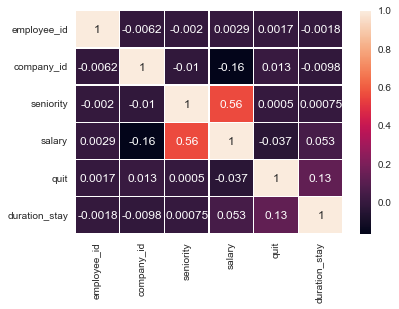

In [26]:
sns.heatmap(df.corr(), annot=True, linewidths=.5)

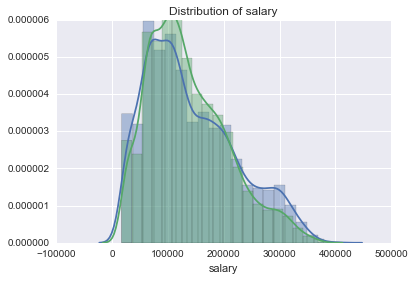

In [27]:
f, ax_hist = plt.subplots(1)
sns.distplot(df_stayed.salary, ax=ax_hist,bins=20)
sns.distplot(df_quit.salary, ax=ax_hist,bins=20)
ax_hist.set(title='Distribution of ' + 'salary')

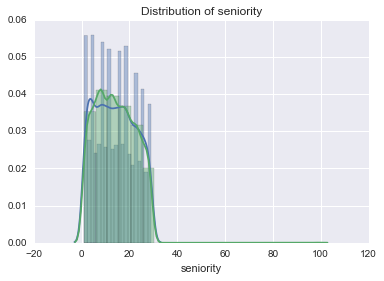

In [28]:
f, ax_hist = plt.subplots(1)
sns.distplot(df_stayed.seniority, ax=ax_hist,bins=20)
sns.distplot(df_quit.seniority, ax=ax_hist,bins=20)
ax_hist.set(title='Distribution of ' + 'seniority')

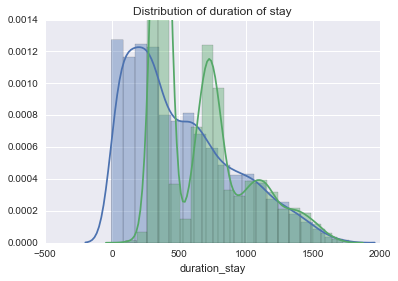

In [29]:
f, ax_hist = plt.subplots(1)
sns.distplot(df_stayed.duration_stay, ax=ax_hist,bins=20)
sns.distplot(df_quit.duration_stay, ax=ax_hist,bins=20)
ax_hist.set(title='Distribution of ' + 'duration of stay')

# Machine learning approaches 
We use Lasso feature selection and linear regression coefficiats to find important factors for a person to stay or leave a job

In [30]:

#df_with_dummies = pd.get_dummies( df[['employee_id','company_id','dept','seniority','join_date','quit_date','salary','quit','duration_stay']],columns = ['dept'] )

#features = list(df_with_dummies.columns)
#df['join_date'] = df['join_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['join_date'] = df['join_date'].apply(lambda x: len(pd.date_range(base,x)))
#df['join_date'] = pd.date_range(base,end)
variables = list(df.columns)
#remove unrelated variables
features =  [var for var in variables if var not in ['quit','quit_date','employee_id','dept']]


In [31]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 5 columns):
company_id       24702 non-null int64
seniority        24702 non-null int64
salary           24702 non-null float64
join_date        24702 non-null int64
duration_stay    24702 non-null int64
dtypes: float64(1), int64(4)
memory usage: 965.0 KB


In [32]:

X = df[features].values
y = df['quit'].values


In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

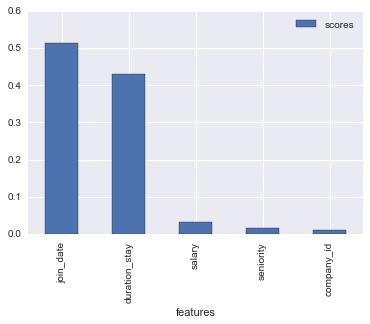

In [34]:
scores = rfc.feature_importances_
feat_importance = pd.DataFrame(columns=["scores","features"])
feat_importance.scores = scores
feat_importance.features = features
feat_importance = feat_importance.sort_values(['scores'],ascending = False)
feat_importance.plot.bar(x='features')

Lasso Alpha is =  0.00017433288222
[(0.0, 'join_date'), (0.0, 'salary'), (0.0, 'seniority'), (0.0265, 'company_id'), (0.3161, 'duration_stay')]


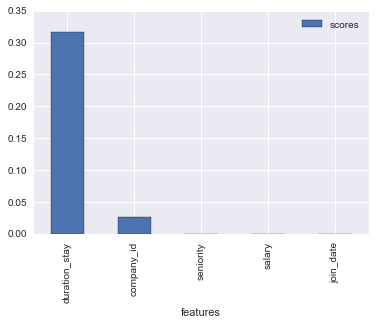

In [35]:
from sklearn.linear_model import LassoCV,Lasso
#Lasso needs normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

threshold = 0
alpha_range = np.logspace(-5, 1, 30)
lasso = LassoCV(alphas=alpha_range, positive=True)

lasso.fit(X, y)
print 'Lasso Alpha is = ', lasso.alpha_
clf = Lasso(alpha=lasso.alpha_, positive=True,random_state=7)
clf.fit(X, y)
#masked_coef = np.ma.masked_greater(clf.coef_, 0).mask

featureCOEForSCOREs = map(lambda x: round(x, 4),  clf.coef_)
featureCOEForSCOREList = zip(featureCOEForSCOREs, features)
print sorted(featureCOEForSCOREList)

scores = clf.coef_
feat_importance = pd.DataFrame(columns=["scores","features"])
feat_importance.scores = scores
feat_importance.features = features
feat_importance = feat_importance.sort_values(['scores'],ascending = False)
feat_importance.plot.bar(x='features')


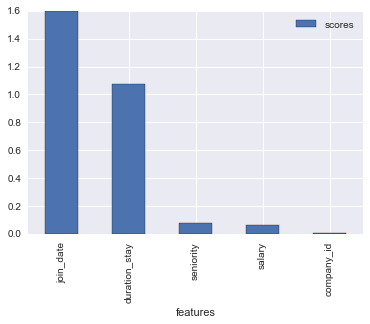

In [36]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
#X is already normalized
lr.fit(X,y)

scores=abs(lr.coef_)
feat_importance = pd.DataFrame(columns=["scores","features"])
feat_importance.scores = scores
feat_importance.features = features
feat_importance = feat_importance.sort_values(['scores'],ascending = False)
feat_importance.plot.bar(x='features')
